
# Cross-Modal Emotion (CWT + Face) — **LOSO + Augment**, using your pairing loader

This notebook replaces the loader with **your `_make_key`-based pairing** (it was working for you),
and keeps:
- Two branches (CWT & Face), each with **4 × (Conv → BN → PReLU → MaxPool)**
- **Cross-Attention** (CWT→Face) via `MultiHeadAttention`
- **3 Dense layers**, softmax over 4 emotions (`happy`, `sad`, `calm`, `angry`)
- **LOSO validation**, **data augmentation**, **AdamW**, **EarlyStopping/ReduceLROnPlateau**
- **Save only the best weights** per subject (`val_loss`)

You can tweak pairing with:
- `key_mode`: `"number"` or `"stem"`
- `key_regex`: numeric pattern to capture the frame index
- `pad_width`, `offset`: zero-pad & shift indices if needed


In [6]:
pip install --upgrade ml-dtypes


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [1]:

import os, sys, random, re
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

np.set_printoptions(linewidth=120)
print('Python:', sys.version)
print('TensorFlow:', tf.__version__)

# GPU setup
gpus = tf.config.list_physical_devices('GPU')
print('GPUs detected:', gpus)
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print('Memory growth set error:', e)

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


Python: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
TensorFlow: 2.16.1
GPUs detected: []


## Configuration

In [2]:

# Root folder: subject -> emotion -> {CWT, Facial_frames}
base_dir = r"E:\Update_data\dataset\nEW_LOSO\AFTER"

# Input shapes
CWT_SHAPE  = (128, 128, 1)  # grayscale
FACE_SHAPE = (64,  64,  3)  # RGB

EMOTIONS = ["happy", "sad", "calm", "angry"]
EMO2IDX = {e:i for i, e in enumerate(EMOTIONS)}
NUM_CLASSES = len(EMOTIONS)

# Pairing settings (from your loader)
KEY_MODE   = "number"          # "number" or "stem"
KEY_REGEX  = r"(\d{1,6})"      # numeric pattern to capture indices
PAD_WIDTH  = 3                 # zero padding for keys
OFFSET     = 0                 # shift (useful if face index = cwt index + offset)

# Training
EPOCHS = 50
BATCH_SIZE = 8
USE_CLASS_WEIGHTS = True

# Optimizer & callbacks
LEARNING_RATE = 3e-4
WEIGHT_DECAY  = 1e-4

# Output directory (best-only checkpoints go here)
WEIGHT_DIR = "weights_loso_pairkey"
os.makedirs(WEIGHT_DIR, exist_ok=True)

print('Base dir:', base_dir)
print('Emotions:', EMOTIONS)
print('Shapes -> CWT:', CWT_SHAPE, ' Face:', FACE_SHAPE)
print('Pairing -> key_mode:', KEY_MODE, ' key_regex:', KEY_REGEX, ' pad_width:', PAD_WIDTH, ' offset:', OFFSET)
print('Epochs:', EPOCHS, ' Batch size:', BATCH_SIZE, ' Class weights:', USE_CLASS_WEIGHTS)


Base dir: E:\Update_data\dataset\nEW_LOSO\AFTER
Emotions: ['happy', 'sad', 'calm', 'angry']
Shapes -> CWT: (128, 128, 1)  Face: (64, 64, 3)
Pairing -> key_mode: number  key_regex: (\d{1,6})  pad_width: 3  offset: 0
Epochs: 50  Batch size: 8  Class weights: True


## Loader (your `_make_key` approach)

In [3]:

import os, re
import numpy as np
from collections import defaultdict, Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def _list_dirs(path):
    return sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

def _list_images(path):
    exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    return sorted([f for f in os.listdir(path) if f.lower().endswith(exts)])

def _stem(fname):
    return os.path.splitext(fname)[0]

def _make_key(stem,
              key_mode="number",
              drop_suffixes=("_cwt","-cwt",".cwt","_face","-face",".face"),
              key_regex=r"(\d{1,6})",
              pad_width=3,
              offset=0):
    s = stem.lower().strip()
    for suf in drop_suffixes:
        if s.endswith(suf):
            s = s[: -len(suf)]
    if key_mode == "stem":
        return s
    # number mode
    m = re.search(r"segment_(\d{1,6})", s)
    if m:
        num = int(m.group(1)) + offset
        return f"{num:0{pad_width}d}"
    nums = re.findall(key_regex, s)
    if nums:
        last = nums[-1]
        if isinstance(last, tuple):
            last = next((g for g in last if g), last[0])
        num = int(last) + offset
        return f"{num:0{pad_width}d}"
    return None

def load_dataset_from_tree(base_dir, cwt_shape, face_shape, emotions,
                           cwt_dirname="CWT", face_dirname="Facial_frames",
                           key_mode="number", key_regex=r"(\d{1,6})",
                           pad_width=3, offset=0):
    cwt_h, cwt_w, _ = cwt_shape
    face_h, face_w, _ = face_shape

    X_cwt, X_face, y, subj_ids = [], [], [], []
    per_subject_emotion_counts = defaultdict(int)
    pairing_stats = defaultdict(lambda: {'cwt_only':0, 'face_only':0, 'paired':0})

    subjects = _list_dirs(base_dir)
    if not subjects:
        raise RuntimeError(f"No subject folders found under: {base_dir}")
    print('Subjects discovered:', subjects)

    EMO2IDX_local = {emo: i for i, emo in enumerate(emotions)}

    for s_idx, subj in enumerate(subjects):
        subj_path = os.path.join(base_dir, subj)

        for emo in emotions:
            emo_path  = os.path.join(subj_path, emo)
            cwt_dir   = os.path.join(emo_path, cwt_dirname)
            face_dir  = os.path.join(emo_path, face_dirname)

            if not os.path.isdir(emo_path):
                print(f"[WARN] Missing emotion folder: {emo_path}")
                continue
            if not os.path.isdir(cwt_dir) or not os.path.isdir(face_dir):
                print(f"[WARN] Missing modality folder under {emo_path} (need {cwt_dirname} & {face_dirname})")
                continue

            cwt_files  = _list_images(cwt_dir)
            face_files = _list_images(face_dir)

            cwt_map, face_map = {}, {}
            for f in cwt_files:
                k = _make_key(_stem(f), key_mode=key_mode, key_regex=key_regex, pad_width=pad_width, offset=offset)
                if k is not None: cwt_map[k] = f
            for f in face_files:
                k = _make_key(_stem(f), key_mode=key_mode, key_regex=key_regex, pad_width=pad_width, offset=offset)
                if k is not None: face_map[k] = f

            common_keys = sorted(set(cwt_map.keys()) & set(face_map.keys()))
            only_cwt    = sorted(set(cwt_map.keys())  - set(face_map.keys()))
            only_face   = sorted(set(face_map.keys()) - set(cwt_map.keys()))

            pairing_stats[(subj, emo)]['paired']    = len(common_keys)
            pairing_stats[(subj, emo)]['cwt_only']  = len(only_cwt)
            pairing_stats[(subj, emo)]['face_only'] = len(only_face)

            for k in common_keys:
                cwt_path  = os.path.join(cwt_dir,  cwt_map[k])
                face_path = os.path.join(face_dir, face_map[k])

                cwt_img = load_img(cwt_path, color_mode='grayscale', target_size=(cwt_h, cwt_w))
                cwt_arr = img_to_array(cwt_img) / 255.0

                face_img = load_img(face_path, color_mode='rgb', target_size=(face_h, face_w))
                face_arr = img_to_array(face_img) / 255.0

                X_cwt.append(cwt_arr.astype('float32'))
                X_face.append(face_arr.astype('float32'))
                y.append(EMO2IDX_local[emo])
                subj_ids.append(s_idx)
                per_subject_emotion_counts[(subj, emo)] += 1

            if len(common_keys) == 0:
                ex_cwt  = list(cwt_map.keys())[:3]
                ex_face = list(face_map.keys())[:3]
                print(f"[NOTE] No pairs for {subj}/{emo}. Example CWT keys: {ex_cwt} | FACE keys: {ex_face}")

    if not X_cwt:
        raise RuntimeError(
            "No paired samples were found. Adjust key_mode/key_regex/pad_width/offset so CWT and FACE filenames yield the same key."
        )

    X_cwt  = np.stack(X_cwt,  axis=0)
    X_face = np.stack(X_face, axis=0)
    y      = to_categorical(np.array(y), num_classes=len(emotions))
    subj_ids = np.array(subj_ids)

    print("\nPairing summary (first 12 rows):")
    shown = 0
    for (subj, emo), stats in pairing_stats.items():
        print(f" {subj:>6} / {emo:<6} -> paired={stats['paired']:>3}  cwt_only={stats['cwt_only']:>3}  face_only={stats['face_only']:>3}")
        shown += 1
        if shown >= 12:
            break

    print("\nLoaded paired samples:", X_cwt.shape[0])
    print("Shapes -> CWT:", X_cwt.shape, " FACE:", X_face.shape, " LABELS:", y.shape, " SUBJECT_IDS:", subj_ids.shape)

    label_ids = np.argmax(y, axis=1)
    emo_counts = Counter(label_ids)
    print("\nOverall emotion distribution:")
    for i, emo in enumerate(emotions):
        print(f"  {emo:<6}: {emo_counts.get(i,0)}")

    subj_counts = Counter(subj_ids)
    print("\nSamples per subject (first 12):")
    for k, v in list(subj_counts.items())[:12]:
        print(f"  subject_idx={k}: {v}")

    return X_cwt, X_face, y, subj_ids, subjects


## Load Dataset & Show a Few Paired Samples

In [4]:

X_CWT, X_FACE, Y, SUBJECT_IDS, SUBJECT_NAMES = load_dataset_from_tree(
    base_dir, CWT_SHAPE, FACE_SHAPE, EMOTIONS,
    cwt_dirname="CWT", face_dirname="Facial_frames",
    key_mode=KEY_MODE, key_regex=KEY_REGEX, pad_width=PAD_WIDTH, offset=OFFSET
)
print('Subjects:', SUBJECT_NAMES)

# Show a few pairs (no augmentation)
def show_pairs(Xcwt, Xface, Y_onehot, n=3):
    import matplotlib.pyplot as plt
    n = min(n, Xcwt.shape[0])
    for i in range(n):
        idx = np.random.randint(0, Xcwt.shape[0])
        emo = EMOTIONS[int(np.argmax(Y_onehot[idx]))]
        plt.figure(figsize=(6,3)); plt.suptitle(f"Pair preview — {emo}")
        plt.subplot(1,2,1); plt.title("CWT");  plt.imshow(Xcwt[idx].squeeze()); plt.axis('off')
        plt.subplot(1,2,2); plt.title("Face"); plt.imshow(np.clip(Xface[idx],0,1)); plt.axis('off')
        plt.show()

show_pairs(X_CWT, X_FACE, Y, n=3)


Subjects discovered: ['p1', 'p10', 'p11', 'p13', 'p14', 'p15', 'p16', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p9']
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p1\happy (need CWT & Facial_frames)
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p1\sad (need CWT & Facial_frames)
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p1\calm (need CWT & Facial_frames)
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p1\angry (need CWT & Facial_frames)
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p10\happy (need CWT & Facial_frames)
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p10\sad (need CWT & Facial_frames)
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p10\calm (need CWT & Facial_frames)
[WARN] Missing modality folder under E:\Update_data\dataset\nEW_LOSO\AFTER\p10\angry (need CWT & Facial_frames)
[W

RuntimeError: No paired samples were found. Adjust key_mode/key_regex/pad_width/offset so CWT and FACE filenames yield the same key.

## Data Augmentation (training only)

Showing a few augmented pairs...



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


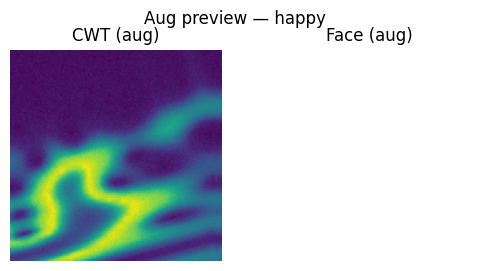

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


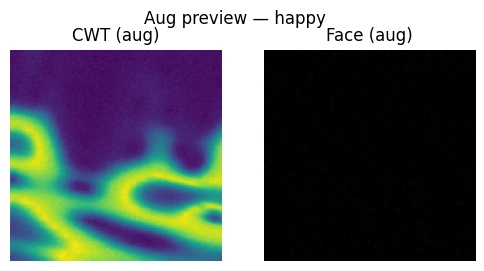

In [6]:

face_aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1, 0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomBrightness(factor=0.1),
    layers.RandomContrast(0.1),
    layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01))
], name='face_aug')

cwt_aug = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05, 0.05),
    layers.RandomTranslation(0.03, 0.03),
    layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01))
], name='cwt_aug')

def make_ds(Xcwt, Xface, Y, batch_size, training=True):
    ds = tf.data.Dataset.from_tensor_slices((Xcwt, Xface, Y))
    if training:
        ds = ds.shuffle(buffer_size=len(Xcwt), seed=SEED, reshuffle_each_iteration=True)
        def aug_map(cwt, face, y):
            cwt  = cwt_aug(cwt, training=True)
            face = face_aug(face, training=True)
            return (cwt, face), y
        ds = ds.map(aug_map, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(lambda cwt, face, y: ((cwt, face), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Preview augmented examples
def show_aug_preview(Xcwt, Xface, Y_onehot, n=2):
    for _ in range(n):
        idx = np.random.randint(0, Xcwt.shape[0])
        ds = make_ds(Xcwt[idx:idx+1], Xface[idx:idx+1], Y_onehot[idx:idx+1], 1, training=True)
        (cwt_aug_img, face_aug_img), _ = next(iter(ds))
        emo = EMOTIONS[int(np.argmax(Y_onehot[idx]))]
        plt.figure(figsize=(6,3)); plt.suptitle(f"Aug preview — {emo}")
        plt.subplot(1,2,1); plt.title("CWT (aug)");  plt.imshow(cwt_aug_img[0].numpy().squeeze()); plt.axis('off')
        plt.subplot(1,2,2); plt.title("Face (aug)");  plt.imshow(face_aug_img[0].numpy());         plt.axis('off')
        plt.show()

print("Showing a few augmented pairs...")
show_aug_preview(X_CWT, X_FACE, Y, n=2)


## Model — Two 4-Block Branches + Cross-Attention + 3 Dense Layers

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, initializers

def zscore_per_sample(name):
    # Standardize each sample: (x - mean)/std over HWC
    return layers.Lambda(
        lambda t: (t - tf.reduce_mean(t, axis=[1,2,3], keepdims=True)) /
                  (tf.math.reduce_std(t, axis=[1,2,3], keepdims=True) + 1e-6),
        name=name
    )

from tensorflow.keras import layers, models, optimizers, initializers

def conv_block(x, filters):
    x = layers.Conv2D(
        filters, 3, padding='same', use_bias=False,
        kernel_initializer=initializers.HeNormal()
    )(x)
    x = layers.LayerNormalization(axis=-1)(x)  # <-- call the layer on x
    x = layers.PReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    return x


def cwt_branch(input_shape, filters=(32,64,128)):
    inp = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255.0)(inp)      # bring to [0,1]
    x = zscore_per_sample("cwt_zscore")(x)   # stabilize scale
    for f in filters:
        x = conv_block(x, f)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    return models.Model(inp, x, name="cwt_encoder")

def face_branch(input_shape, filters=(32,64,128)):
    inp = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255.0)(inp)      # [0,1]
    x = zscore_per_sample("face_zscore")(x)  # match CWT treatment
    for f in filters:
        x = conv_block(x, f)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    return models.Model(inp, x, name="face_encoder")

def build_fusion_baseline(cwt_shape, face_shape, num_classes=4, lr=1e-3, dropout=0.2):
    cwt_enc  = cwt_branch(cwt_shape)
    face_enc = face_branch(face_shape)

    in_cwt  = layers.Input(shape=cwt_shape,  name="cwt_input")
    in_face = layers.Input(shape=face_shape, name="face_input")

    e_cwt  = cwt_enc(in_cwt)
    e_face = face_enc(in_face)

    fused = layers.Concatenate()([e_cwt, e_face])
    x = layers.Dropout(dropout)(fused)
    x = layers.Dense(256, activation='relu',
                     kernel_initializer=initializers.HeNormal())(x)
    out = layers.Dense(num_classes, activation='softmax', name='emotion')(x)

    model = models.Model([in_cwt, in_face], out, name="fusion_baseline_clean")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [8]:
def make_ds(Xcwt, Xface, Y, batch_size, training):
    Xcwt = Xcwt.astype('float32'); Xface = Xface.astype('float32'); Y = Y.astype('float32')
    ds = tf.data.Dataset.from_tensor_slices(((Xcwt, Xface), Y))
    if training: ds = ds.shuffle(len(Y), reshuffle_each_iteration=True)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


## Helper: Class Weights

In [9]:

def compute_class_weights(y_onehot, num_classes):
    y_int = np.argmax(y_onehot, axis=1)
    counts = Counter(y_int); total = len(y_int)
    weights = {cls: total / (num_classes * counts.get(cls, 1)) for cls in range(num_classes)}
    print('Class counts:', dict(counts)); print('Class weights:', weights)
    return weights


## LOSO Training (Save **Best Only** by `val_loss`)


===== LOSO: Holding out subject [0] p1 =====
Train size: 706  Dev size: 78  Test size: 84
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.2712 - loss: 1.5435
Epoch 1: val_loss improved from inf to 1.48986, saving model to weights_loso_pairkey\loso_subj_0_best.weights.h5
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 379ms/step - accuracy: 0.2708 - loss: 1.5429 - val_accuracy: 0.1923 - val_loss: 1.4899 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.2986 - loss: 1.3933
Epoch 2: val_loss improved from 1.48986 to 1.42311, saving model to weights_loso_pairkey\loso_subj_0_best.weights.h5
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.2983 - loss: 1.3934 - val_accuracy: 0.2179 - val_loss: 1.4231 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.2367 - loss: 1.4107
Epoch 3: val_loss improved from 1.42311 to 1.40707, saving model to weights_loso_pairkey\loso_subj_0_best.weights.h5
89/89 ━━━━━━━━━━━━━━

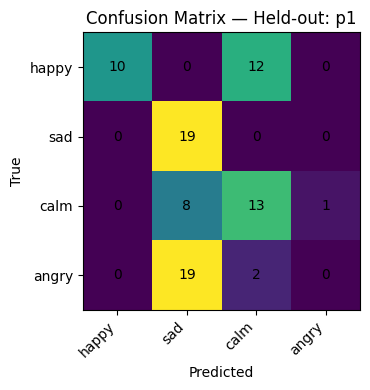


===== LOSO: Holding out subject [1] p10 =====
Train size: 703  Dev size: 78  Test size: 87
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.2611 - loss: 1.5496
Epoch 1: val_loss improved from inf to 1.41592, saving model to weights_loso_pairkey\loso_subj_1_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 424ms/step - accuracy: 0.2609 - loss: 1.5488 - val_accuracy: 0.2051 - val_loss: 1.4159 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2552 - loss: 1.4183
Epoch 2: val_loss did not improve from 1.41592
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.2554 - loss: 1.4184 - val_accuracy: 0.2692 - val_loss: 1.4486 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.2322 - loss: 1.4178
Epoch 3: val_loss did not improve from 1.41592
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 369ms/step - accuracy: 0.2323 - loss: 1.4177 - val_accuracy: 0.2051 - val_loss: 1.4214 - learning_rate: 0.0010
Epoch 4/50
88/88 

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

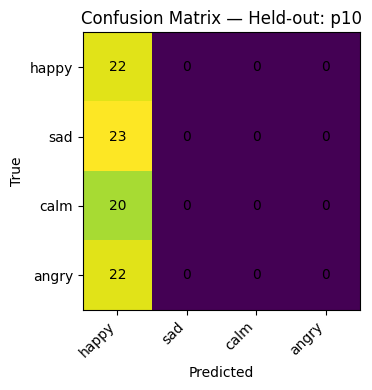


===== LOSO: Holding out subject [2] p14 =====
Train size: 703  Dev size: 78  Test size: 87
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.2637 - loss: 1.5292
Epoch 1: val_loss improved from inf to 1.40949, saving model to weights_loso_pairkey\loso_subj_2_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 380ms/step - accuracy: 0.2636 - loss: 1.5286 - val_accuracy: 0.2692 - val_loss: 1.4095 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.2676 - loss: 1.4165
Epoch 2: val_loss did not improve from 1.40949
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.2676 - loss: 1.4163 - val_accuracy: 0.2692 - val_loss: 1.4416 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.2359 - loss: 1.4049
Epoch 3: val_loss improved from 1.40949 to 1.37870, saving model to weights_loso_pairkey\loso_subj_2_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 380ms/step - accuracy: 0.2360 - loss: 1.4049 - val_accurac

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

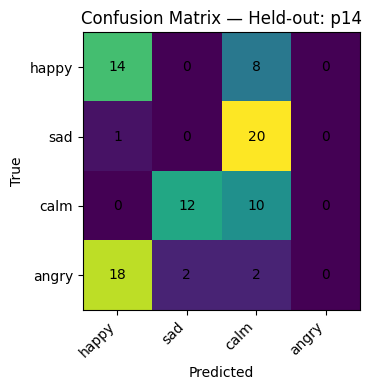


===== LOSO: Holding out subject [3] p15 =====
Train size: 702  Dev size: 78  Test size: 88
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.3113 - loss: 1.5646
Epoch 1: val_loss improved from inf to 1.39827, saving model to weights_loso_pairkey\loso_subj_3_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 382ms/step - accuracy: 0.3111 - loss: 1.5635 - val_accuracy: 0.2564 - val_loss: 1.3983 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2692 - loss: 1.4219
Epoch 2: val_loss did not improve from 1.39827
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.2693 - loss: 1.4218 - val_accuracy: 0.2051 - val_loss: 1.3997 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2398 - loss: 1.4078
Epoch 3: val_loss did not improve from 1.39827
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.2398 - loss: 1.4078 - val_accuracy: 0.2564 - val_loss: 1.4099 - learning_rate: 0.0010
Epoch 4/50
88/88 

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

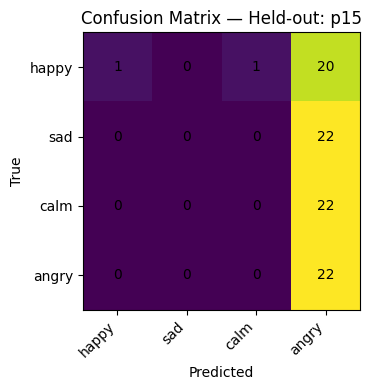


===== LOSO: Holding out subject [4] p3 =====
Train size: 703  Dev size: 78  Test size: 87
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2415 - loss: 1.6099
Epoch 1: val_loss improved from inf to 1.37123, saving model to weights_loso_pairkey\loso_subj_4_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 380ms/step - accuracy: 0.2415 - loss: 1.6087 - val_accuracy: 0.3718 - val_loss: 1.3712 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.2690 - loss: 1.3993
Epoch 2: val_loss improved from 1.37123 to 1.35182, saving model to weights_loso_pairkey\loso_subj_4_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 377ms/step - accuracy: 0.2687 - loss: 1.3995 - val_accuracy: 0.2692 - val_loss: 1.3518 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2659 - loss: 1.3922
Epoch 3: val_loss did not improve from 1.35182
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.2657 - loss: 1.3923 - val_accuracy

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

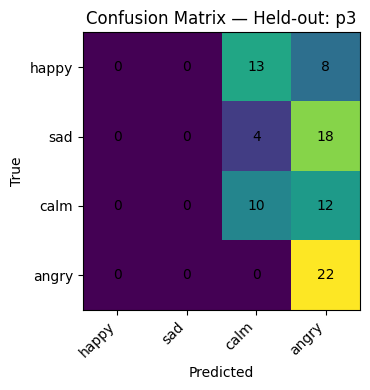


===== LOSO: Holding out subject [5] p4 =====
Train size: 702  Dev size: 78  Test size: 88
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.1982 - loss: 1.6276
Epoch 1: val_loss improved from inf to 1.44917, saving model to weights_loso_pairkey\loso_subj_5_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 381ms/step - accuracy: 0.1984 - loss: 1.6264 - val_accuracy: 0.2564 - val_loss: 1.4492 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1948 - loss: 1.4252
Epoch 2: val_loss improved from 1.44917 to 1.40234, saving model to weights_loso_pairkey\loso_subj_5_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 375ms/step - accuracy: 0.1953 - loss: 1.4250 - val_accuracy: 0.2564 - val_loss: 1.4023 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.3019 - loss: 1.3937
Epoch 3: val_loss improved from 1.40234 to 1.38839, saving model to weights_loso_pairkey\loso_subj_5_best.weights.h5
88/88 ━━━━━━━━━━━━━━

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

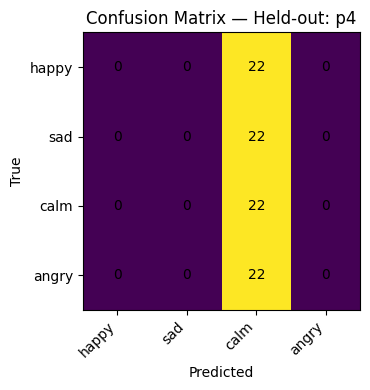


===== LOSO: Holding out subject [6] p5 =====
Train size: 706  Dev size: 78  Test size: 84
Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.2343 - loss: 1.5777
Epoch 1: val_loss improved from inf to 1.40711, saving model to weights_loso_pairkey\loso_subj_6_best.weights.h5
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 378ms/step - accuracy: 0.2342 - loss: 1.5767 - val_accuracy: 0.2692 - val_loss: 1.4071 - learning_rate: 0.0010
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.2393 - loss: 1.4233
Epoch 2: val_loss did not improve from 1.40711
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 375ms/step - accuracy: 0.2395 - loss: 1.4233 - val_accuracy: 0.1667 - val_loss: 1.4563 - learning_rate: 0.0010
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.2631 - loss: 1.4041
Epoch 3: val_loss did not improve from 1.40711
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 369ms/step - accuracy: 0.2630 - loss: 1.4042 - val_accuracy: 0.2308 - val_loss: 1.4110 - learning_rate: 0.0010
Epoch 4/50
89/89 ━

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

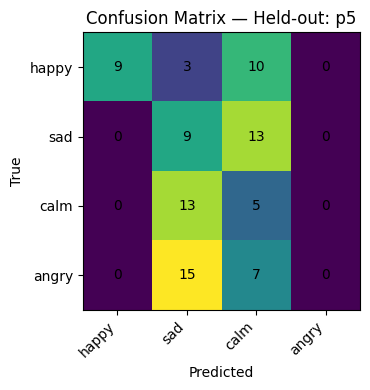


===== LOSO: Holding out subject [7] p6 =====
Train size: 703  Dev size: 78  Test size: 87
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.2583 - loss: 1.5584
Epoch 1: val_loss improved from inf to 1.43407, saving model to weights_loso_pairkey\loso_subj_7_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 387ms/step - accuracy: 0.2582 - loss: 1.5576 - val_accuracy: 0.2564 - val_loss: 1.4341 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.2581 - loss: 1.4141
Epoch 2: val_loss improved from 1.43407 to 1.41354, saving model to weights_loso_pairkey\loso_subj_7_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 34s 392ms/step - accuracy: 0.2580 - loss: 1.4141 - val_accuracy: 0.2564 - val_loss: 1.4135 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.2578 - loss: 1.4138
Epoch 3: val_loss improved from 1.41354 to 1.40404, saving model to weights_loso_pairkey\loso_subj_7_best.weights.h5
88/88 ━━━━━━━━━━━━━━

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

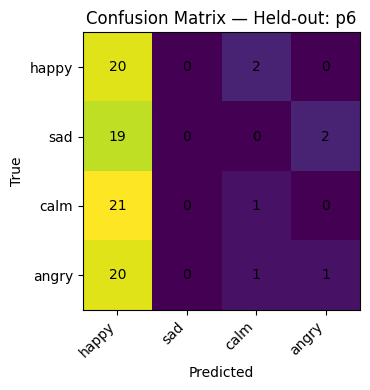


===== LOSO: Holding out subject [8] p7 =====
Train size: 702  Dev size: 78  Test size: 88
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.2610 - loss: 1.5300
Epoch 1: val_loss improved from inf to 1.38746, saving model to weights_loso_pairkey\loso_subj_8_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 393ms/step - accuracy: 0.2610 - loss: 1.5293 - val_accuracy: 0.3077 - val_loss: 1.3875 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.2338 - loss: 1.4206
Epoch 2: val_loss improved from 1.38746 to 1.38096, saving model to weights_loso_pairkey\loso_subj_8_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 374ms/step - accuracy: 0.2339 - loss: 1.4205 - val_accuracy: 0.2436 - val_loss: 1.3810 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2218 - loss: 1.4047
Epoch 3: val_loss did not improve from 1.38096
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 373ms/step - accuracy: 0.2222 - loss: 1.4047 - val_accuracy

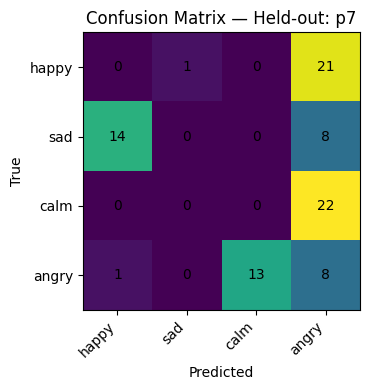


===== LOSO: Holding out subject [9] p9 =====
Train size: 702  Dev size: 78  Test size: 88
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.2413 - loss: 1.4900
Epoch 1: val_loss improved from inf to 1.39441, saving model to weights_loso_pairkey\loso_subj_9_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 386ms/step - accuracy: 0.2413 - loss: 1.4898 - val_accuracy: 0.2564 - val_loss: 1.3944 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.2333 - loss: 1.4257
Epoch 2: val_loss improved from 1.39441 to 1.38053, saving model to weights_loso_pairkey\loso_subj_9_best.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 375ms/step - accuracy: 0.2334 - loss: 1.4256 - val_accuracy: 0.2564 - val_loss: 1.3805 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.2424 - loss: 1.3971
Epoch 3: val_loss did not improve from 1.38053
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 372ms/step - accuracy: 0.2425 - loss: 1.3971 - val_accuracy

C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AIoT-2418\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

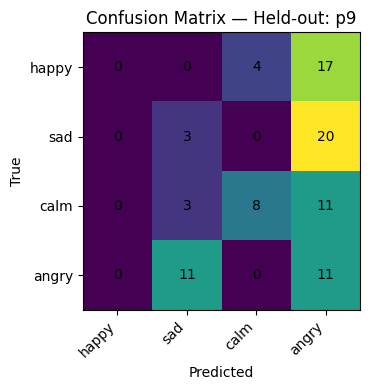

In [14]:
for test_idx, subj_name in enumerate(SUBJECT_NAMES):
    tf.keras.backend.clear_session()

    train_mask = SUBJECT_IDS != test_idx
    test_mask  = SUBJECT_IDS == test_idx

    # ---- create a small DEV split from TRAIN subjects (no test leakage) ----
    rng = np.random.default_rng(42 + test_idx)
    train_indices = np.where(train_mask)[0]
    n_dev = max(1, int(0.1 * len(train_indices)))   # 10% of train as dev
    dev_indices = rng.choice(train_indices, size=n_dev, replace=False)

    dev_mask = np.zeros_like(train_mask, dtype=bool)
    dev_mask[dev_indices] = True

    tr_mask2 = train_mask & ~dev_mask   # final train
    dv_mask2 = dev_mask                 # dev/validation (from train subjects)

    # slice arrays
    Xcwt_tr, Xface_tr, Y_tr = X_CWT[tr_mask2],  X_FACE[tr_mask2],  Y[tr_mask2]
    Xcwt_dv, Xface_dv, Y_dv = X_CWT[dv_mask2],  X_FACE[dv_mask2],  Y[dv_mask2]
    Xcwt_te, Xface_te, Y_te = X_CWT[test_mask], X_FACE[test_mask], Y[test_mask]

    print(f"\n===== LOSO: Holding out subject [{test_idx}] {subj_name} =====")
    print('Train size:', Xcwt_tr.shape[0], ' Dev size:', Xcwt_dv.shape[0], ' Test size:', Xcwt_te.shape[0])

    ds_train = make_ds(Xcwt_tr, Xface_tr, Y_tr, batch_size=BATCH_SIZE, training=True)
    ds_dev   = make_ds(Xcwt_dv, Xface_dv, Y_dv, batch_size=BATCH_SIZE, training=False)
    ds_test  = make_ds(Xcwt_te, Xface_te, Y_te, batch_size=BATCH_SIZE, training=False)

    model = build_fusion_baseline(CWT_SHAPE, FACE_SHAPE, num_classes=NUM_CLASSES)

    weight_file = os.path.join(WEIGHT_DIR, f"loso_subj_{test_idx}_best.weights.h5")
    cb = [
        callbacks.ModelCheckpoint(
            weight_file, monitor="val_loss",
            save_best_only=True, save_weights_only=True, verbose=1
        ),
        callbacks.EarlyStopping(
            monitor="val_loss", patience=6, restore_best_weights=True, verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
        ),
    ]

    # ---- train on TRAIN, validate on DEV (not on TEST!) ----
    history = model.fit(
        ds_train,
        validation_data=ds_dev,
        epochs=EPOCHS,
        callbacks=cb,
        verbose=1
    )

    # load best on dev and evaluate on TEST subject
    if os.path.exists(weight_file):
        model.load_weights(weight_file)
        print('Loaded best weights from:', weight_file)

    loss, acc = model.evaluate(ds_test, verbose=0)
    print(f"Held-out {subj_name} — Accuracy: {acc:.4f}")
    loso_scores.append(acc)

    # Confusion matrix on TEST
    y_true = np.argmax(Y_te, axis=1)
    y_pred = np.argmax(model.predict(ds_test, verbose=0), axis=1)
    print('\nClassification Report (held-out subject:', subj_name, ')')
    print(classification_report(y_true, y_pred, target_names=EMOTIONS, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    fig = plt.figure(figsize=(5,4))
    plt.title(f'Confusion Matrix — Held-out: {subj_name}')
    plt.imshow(cm)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.xticks(range(NUM_CLASSES), EMOTIONS, rotation=45, ha='right')
    plt.yticks(range(NUM_CLASSES), EMOTIONS)
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center')
    plt.tight_layout(); plt.show()
